Imports

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
import pickle
import time

import sys
sys.stdout = open('output_of_LR_fasttext.txt','wt')

#### Load data

In [2]:
X = np.load('data/X_fasttext_embeddings.npy') 
y = np.load('data/y_binarized.npy') 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
#creating a validation set for hyperparameter tuning
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)


Tags for plotting

In [3]:
tags = np.load('data/y_tags.npy', allow_pickle=True)
tags

array(['astro-ph.IM', 'cond-mat.dis-nn', 'cond-mat.mtrl-sci',
       'cond-mat.stat-mech', 'cs.AI', 'cs.AR', 'cs.CC', 'cs.CE', 'cs.CG',
       'cs.CL', 'cs.CR', 'cs.CV', 'cs.CY', 'cs.DB', 'cs.DC', 'cs.DL',
       'cs.DM', 'cs.DS', 'cs.ET', 'cs.FL', 'cs.GL', 'cs.GR', 'cs.GT',
       'cs.HC', 'cs.IR', 'cs.IT', 'cs.LG', 'cs.LO', 'cs.MA', 'cs.MM',
       'cs.MS', 'cs.NA', 'cs.NE', 'cs.NI', 'cs.OH', 'cs.OS', 'cs.PF',
       'cs.PL', 'cs.RO', 'cs.SC', 'cs.SD', 'cs.SE', 'cs.SI', 'cs.SY',
       'econ.EM', 'econ.GN', 'econ.TH', 'eess.AS', 'eess.IV', 'eess.SP',
       'eess.SY', 'hep-ex', 'math-ph', 'math.AC', 'math.AG', 'math.AP',
       'math.AT', 'math.CA', 'math.CO', 'math.CT', 'math.DG', 'math.DS',
       'math.FA', 'math.GR', 'math.IT', 'math.LO', 'math.MG', 'math.MP',
       'math.NA', 'math.NT', 'math.OC', 'math.PR', 'math.RA', 'math.RT',
       'math.ST', 'nlin.AO', 'nlin.CD', 'nlin.CG', 'physics.ao-ph',
       'physics.app-ph', 'physics.bio-ph', 'physics.chem-ph',
       'physics.comp

# Logistic Regression

LR multiple binary classifiers

In [11]:
def train_LR(C = 1, name=None):
    LR_model_list = []
    for i in range(y_train.shape[1]):
        sample_y_train = y_train[:, i]
        LR_clf_single = LogisticRegression(n_jobs=-1, C=C, solver='saga')
        LR_clf_single.fit(X_train, sample_y_train)
        LR_model_list.append(LR_clf_single)
    with open(name, 'wb') as f:
        pickle.dump(LR_model_list, f)
    return LR_model_list

    

In [5]:
def pred_LR(model, x_data):
    return model.predict(x_data)

In [6]:
def calc_scores(name, LR_model_list):
    precision_tr = []
    precision_v = []
    recall_tr = []
    recall_v = []
    f1_tr = []
    f1_v = []
    accu_tr = []
    accu_v = []
    
    for i in range(len(LR_model_list)):
        y_pred_tr = pred_LR(LR_model_list[i], X_train)
        y_pred_v = pred_LR(LR_model_list[i] ,(X_val))

        precision_tr.append(precision_score(y_pred=y_pred_tr, y_true=y_train[:,i]))
        precision_v.append(precision_score(y_pred=y_pred_v, y_true=y_val[:,i]))

        recall_tr.append(recall_score(y_pred=y_pred_tr, y_true=y_train[:,i]))
        recall_v.append(recall_score(y_pred=y_pred_v, y_true=y_val[:,i]))

        f1_tr.append(f1_score(y_pred=y_pred_tr, y_true=y_train[:,i]))
        f1_v.append(f1_score(y_pred=y_pred_v, y_true=y_val[:,i]))

        accu_tr.append(accuracy_score(y_pred=y_pred_tr, y_true=y_train[:,i]))
        accu_v.append(accuracy_score(y_pred=y_pred_v, y_true=y_val[:,i]))

    with open("./results/precision_C_tr_"+name+".txt", "w") as output:
        output.write(str(y_pred_tr))
    with open("./results/precision_C_v_"+name+".txt", "w") as output:
        output.write(str(y_pred_v))
    with open("./results/recall_C_tr"+name+".txt", "w") as output:
        output.write(str(recall_tr))
    with open("./results/recall_C_v"+name+".txt", "w") as output:
        output.write(str(recall_v))
    with open("./results/f1_C_tr"+name+".txt", "w") as output:
        output.write(str(f1_tr))
    with open("./results/f1_C_v"+name+".txt", "w") as output:
        output.write(str(f1_v))
    with open("./results/accu_C_tr"+name+".txt", "w") as output:
        output.write(str(accu_tr))
    with open("./results/accu_C_v"+name+".txt", "w") as output:
        output.write(str(accu_v))
    
    return precision_tr, precision_v, recall_tr, recall_v, f1_tr, f1_v, accu_tr, accu_v

In [7]:
def plotting_metrics(metric_list, name, tags=tags):
    disp_df = pd.DataFrame(
        {'tags': tags,
        'prec': metric_list
        })
    disp_df = disp_df.sort_values(by = 'prec' , ascending=False)
    plt.figure(figsize=(300, 200), dpi=200)
    plt.bar(disp_df['tags'], disp_df['prec'])
    plt.xticks(fontsize=10)
    plt.savefig(name)

In [12]:
start_time = time.time()
LR_model_list = train_LR(C=1, name='LR_C_large_model_list.pkl')
print('Execution time for LR with C=1, for fasttext embeddings',time.time()-start_time)


/Users/siddhipotdar/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
start_time = time.time()
LR_model_list_bal = train_LR(C=0.01, name='LR_C_med_model_list.pkl')
print('Execution time for LR with C=0.1, for fasttext embeddings',time.time()-start_time)

In [ ]:
start_time = time.time()
LR_model_list_small = train_LR(C=0.001,name='LR_C_small_model_list.pkl')
print('Execution time for LR with C=0.001, for fasttext embeddings',time.time()-start_time)


In [13]:

LR_model_list_large = pickle.load(open('LR_none_wt_model_list.pkl', 'rb'))
LR_model_list_med = pickle.load(open('LR_bal_wt_model_list.pkl', 'rb'))
LR_model_list_small = pickle.load(open('LR_small_wt_model_list.pkl', 'rb'))

In [ ]:
precision_C_large_tr, precision_C_large_v,recall_C_large_tr,recall_C_large_v, f1_C_large_tr, f1_C_large_v, accu_C_large_tr, accu_C_large_v = calc_scores('C_large',LR_model_list_large)
f1_mean_C_large_v = np.mean(f1_C_large_v)
accu_mean_C_large_v = np.mean(accu_C_large_v)
print("F1 mean for C=1: ", f1_mean_C_large_v)
print("accuracy mean for C=1: ", accu_mean_C_large_v)

In [ ]:
plotting_metrics(recall_C_large_v, './results/recall_C_large.png')
plotting_metrics(f1_C_large_v, './results/f1_C_large_v.png')
plotting_metrics(precision_C_large_v, './results/precision_C_large_v.png')

In [ ]:
precision_C_med_tr, precision_C_med_v,recall_C_med_tr,recall_C_med_v, f1_C_med_tr, f1_C_med_v, accu_C_med_tr, accu_C_med_v = calc_scores('med',LR_model_list_bal)
f1_mean_C_med_v = np.mean(f1_C_med_v)
accu_mean_C_med_v = np.mean(accu_C_med_v)
print("F1 mean for C=0.1: ", f1_mean_C_med_v)
print("accuracy mean for C=0.1: ", accu_mean_C_med_v)

In [ ]:
plotting_metrics(recall_C_med_v, './results/recall_C_med.png')
plotting_metrics(f1_C_med_v, './results/f1_C_med_v.png')
plotting_metrics(precision_C_med_v, './results/precision_C_med_v.png')

In [ ]:
precision_C_small_tr, precision_C_small_v,recall_C_small_tr,recall_C_small_v, f1_C_small_tr, f1_C_small_v, accu_C_small_tr, accu_C_small_v = calc_scores('small',LR_model_list_small)
f1_mean_C_small_v = np.mean(f1_C_small_v)
accu_mean_C_small_v = np.mean(accu_C_small_v)
print("F1 mean for C=0.01: ", f1_mean_C_small_v)
print("accuracy mean for C=0.01: ", accu_mean_C_small_v)

In [ ]:
plotting_metrics(recall_C_small_v, './results/recall_C_small.png')
plotting_metrics(f1_C_small_v, './results/f1_C_small_v.png')
plotting_metrics(precision_C_small_v, './results/precision_C_small_v.png')

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
idx_good = np.where(tags=='cs.LG')[0][0]
idx_avg = np.where(tags=='cs.NE')[0][0]
idx_bad = np.where(tags=='cs.NA')[0][0]
print(idx_avg)
y_pred_v_good = SVM_model_list[idx_good].predict(X_val)
y_pred_v_avg = SVM_model_list[idx_avg].predict(X_val)
y_pred_v_bad = SVM_model_list[idx_bad].predict(X_val)

m_good = confusion_matrix(y_pred=y_pred_v_good, y_true=y_val[:,idx_good])
m_avg = confusion_matrix(y_pred=y_pred_v_avg, y_true=y_val[:,idx_avg])
m_bad = confusion_matrix(y_pred=y_pred_v_bad, y_true=y_val[:,idx_bad])


32


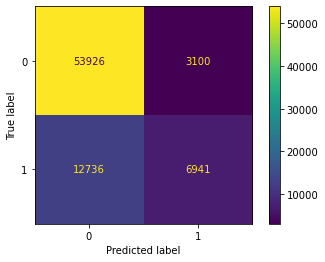

In [ ]:
plt_good = ConfusionMatrixDisplay(m_good).plot()

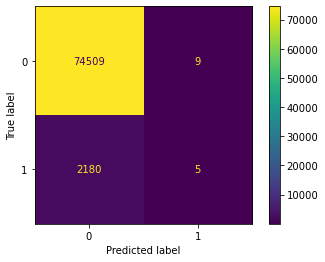

In [ ]:
plt_avg = ConfusionMatrixDisplay(m_avg).plot()

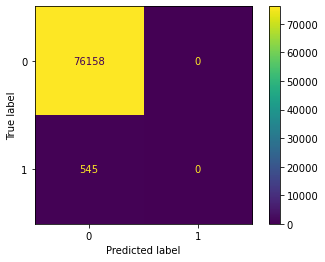

In [ ]:
plt_bad = ConfusionMatrixDisplay(m_bad).plot()

In [ ]:
idx_good = np.where(tags=='cs.LG')[0][0]
idx_avg = np.where(tags=='cs.NE')[0][0]
idx_bad = np.where(tags=='cs.NA')[0][0]
print(idx_avg)
y_pred_v_good = SVM_model_list_bal[idx_good].predict(X_val)
y_pred_v_avg = SVM_model_list_bal[idx_avg].predict(X_val)
y_pred_v_bad = SVM_model_list_bal[idx_bad].predict(X_val)

m_good = confusion_matrix(y_pred=y_pred_v_good, y_true=y_val[:,idx_good])
m_avg = confusion_matrix(y_pred=y_pred_v_avg, y_true=y_val[:,idx_avg])
m_bad = confusion_matrix(y_pred=y_pred_v_bad, y_true=y_val[:,idx_bad])

32


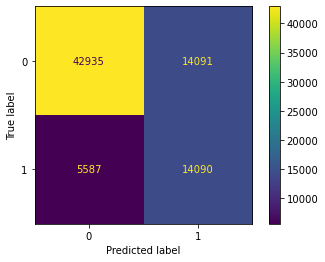

In [ ]:
plt_good = ConfusionMatrixDisplay(m_good).plot()

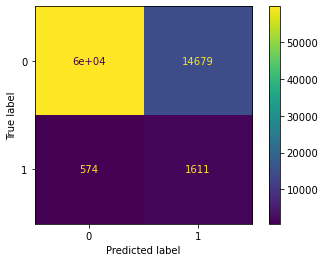

In [ ]:
plt_avg = ConfusionMatrixDisplay(m_avg).plot()

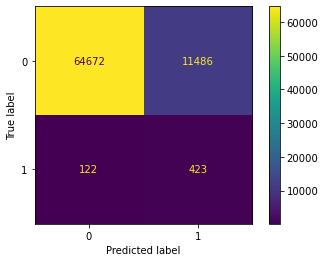

In [ ]:
plt_bad = ConfusionMatrixDisplay(m_bad).plot()

In [ ]:
idx_good = np.where(tags=='cs.LG')[0][0]
idx_avg = np.where(tags=='cs.NE')[0][0]
idx_bad = np.where(tags=='cs.NA')[0][0]
print(idx_avg)
y_pred_v_good = SVM_model_list_self[idx_good].predict(X_val)
y_pred_v_avg = SVM_model_list_self[idx_avg].predict(X_val)
y_pred_v_bad = SVM_model_list_self[idx_bad].predict(X_val)

m_good = confusion_matrix(y_pred=y_pred_v_good, y_true=y_val[:,idx_good])
m_avg = confusion_matrix(y_pred=y_pred_v_avg, y_true=y_val[:,idx_avg])
m_bad = confusion_matrix(y_pred=y_pred_v_bad, y_true=y_val[:,idx_bad])

32


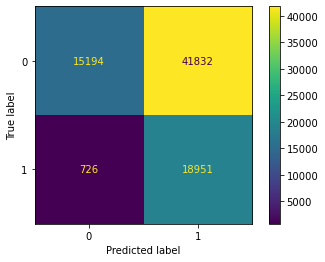

In [ ]:
plt_good = ConfusionMatrixDisplay(m_good).plot()

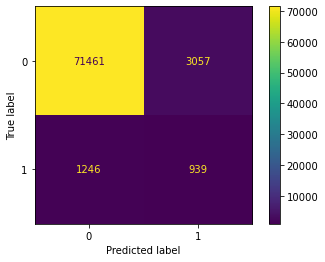

In [ ]:
plt_avg = ConfusionMatrixDisplay(m_avg).plot()

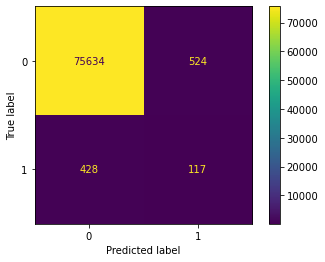

In [ ]:
plt_bad = ConfusionMatrixDisplay(m_bad).plot()

CSAI

In [9]:
# sample_y_train2 = y_train[:, 18]
# sample_y_test2 = y_test[:, 18]
# sample_y_train2.reshape(-1,1)
# sample_y_test2.reshape(-1,1)

array([[0],
       [1],
       [0],
       ...,
       [0],
       [0],
       [0]])

In [20]:
# SVM_clf_csai = LinearSVC(dual=False, class_weight="balanced")
# SVM_clf_csai.fit(X_train, sample_y_train2)
# y_pred_svm_class2 = SVM_clf_csai.predict(X_test)

In [14]:
# SVM_clf_csai1 = LinearSVC(dual=False, class_weight={0:1, 1:10})
# SVM_clf_csai1.fit(X_train, sample_y_train2)
# y_pred_svm_class2 = SVM_clf_csai1.predict(X_test)

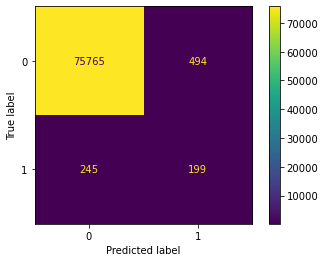

In [18]:
# from sklearn.metrics import ConfusionMatrixDisplay
# m = confusion_matrix(y_pred=y_pred_svm_class2, y_true=sample_y_test2)
# ConfusionMatrixDisplay(m).plot()

              precision    recall  f1-score   support

           0       1.00      0.90      0.95     76259
           1       0.05      0.82      0.09       444

    accuracy                           0.90     76703
   macro avg       0.52      0.86      0.52     76703
weighted avg       0.99      0.90      0.94     76703



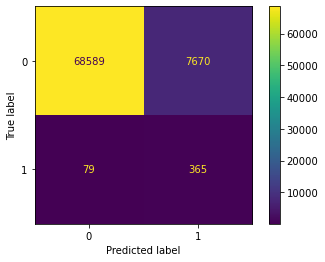

In [21]:
# m = confusion_matrix(y_pred=y_pred_svm_class2, y_true=sample_y_test2)
# from sklearn.metrics import classification_report
# print(classification_report(y_pred=y_pred_svm_class2, y_true=sample_y_test2))
# m = confusion_matrix(y_pred=y_pred_svm_class2, y_true=sample_y_test2)
# ConfusionMatrixDisplay(m).plot()
# #print(m[0][0]/(m[0][0]+m[1]))

In [ ]:
#SVM_model_list_bal


In [6]:
# y_pred_train = clf.predict(X_train)
# bin_acc_train = []
# for col in range(y_train.shape[1]):
#     cnt=0
#     for j in range(y_train.shape[0]):
#         if y_train[j][col] == y_pred_train[j][col]:
#             cnt+=1
#     bin_acc_train.append(cnt/(y_train.shape[0]))